<a href="https://colab.research.google.com/github/edwinb-ai/segnet/blob/master/ejemplos/full_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
!pip install -U git+https://github.com/qubvel/segmentation_models.git

  Cloning https://github.com/qubvel/segmentation_models.git to /tmp/pip-req-build-kbfp0r23
  Running command git clone -q https://github.com/qubvel/segmentation_models.git /tmp/pip-req-build-kbfp0r23
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.0b1-cp36-none-any.whl size=33615 sha256=eb26137164371b62a283b40b3be9339a2274d3dae903d7645338de64465d2a88
  Stored in directory: /tmp/pip-ephem-wheel-cache-7ebqjmsj/wheels/d6/18/c4/340b3ee7253119ec907ec8cf93bd2c572ee9a75eedb183b2f8
Successfully built segmentation-models
  Found existing installation: segmentation-models 1.0.0b1
    Uninstalling segmentation-models-1.0.0b1:
      Successfully uninstalled segmentation-models-1.0.0b1


In [0]:
import segmentation_models as sm
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import glob
from skimage import io
import numpy as np
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [0]:
epochs = 20
batch_size = 32

In [0]:
path_train = "/content/drive/My Drive/Colab Notebooks/DRIVE/training/images/"
path_test = "/content/drive/My Drive/Colab Notebooks/DRIVE/test/images/"
path_mask = "/content/drive/My Drive/Colab Notebooks/DRIVE/training/1st_manual/"
path_mask_test = "/content/drive/My Drive/Colab Notebooks/DRIVE/test/1st_manual/"

X = []
y = []
X_val = []
y_val = []

#TODO: Importar las imágenes en orden!!!

for i in range(21, 41):
    img_name = f"{i}_training.tif"
    X.append(io.imread(path_train + img_name))
    
    mask_name = f"{i}_manual1.gif"
    y.append(io.imread(path_mask + mask_name))
    
for i in range(1, 21):
    img_name = f"{i:02d}_test.tif"
    X_val.append(io.imread(path_test + img_name))
    
    mask_name = f"{i:02d}_manual1.gif"
    y_val.append(io.imread(path_mask_test + mask_name))
    
X = np.array(X, dtype=np.float32)
y = np.array(y, dtype=np.float32)
X_val = np.array(X_val, dtype=np.float32)
y_val = np.array(y_val, dtype=np.float32)

/usr/local/lib/python3.6/dist-packages/skimage/external/tifffile/tifffile.py:2616: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


In [0]:
print(X.shape, y.shape)
print(X_val.shape, y_val.shape)

(20, 584, 565, 3) (20, 584, 565)
(20, 584, 565, 3) (20, 584, 565)


In [0]:
y = y[:, :, :, None]
y_val = y_val[:, :, :, None]

In [0]:
print(X.shape, y.shape)

(20, 584, 565, 3) (20, 584, 565, 1)


In [0]:
X /= 255
y /= 255
X_val /= 255
y_val /=255

In [0]:
%run "/content/drive/My Drive/Colab Notebooks/preprocesamiento.py"

In [0]:
X_test, y_test = muchas_imagenes_en_partes(X, y,
                                           size=(64, 64),
                                           num_partes=9)
X_val_patches, y_val_patches = muchas_imagenes_en_partes(X_val, y_val,
                                                         size=(64, 64),
                                                         num_partes=9)

In [0]:
print(X_test.shape, y_test.shape)

(180, 64, 64, 3) (180, 64, 64, 1)


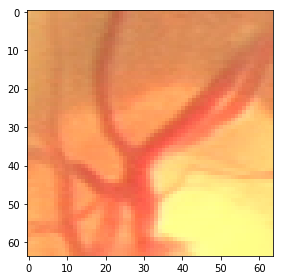

In [0]:
io.imshow(X_test[0])

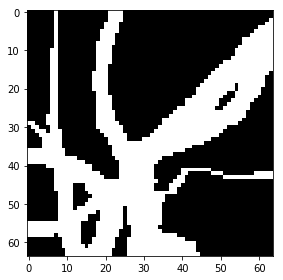

In [0]:
io.imshow(y_test[0, :, :, 0])

In [0]:
transformaciones = dict(
        rotation_range=35.0,
        height_shift_range=0.05,
        width_shift_range=0.05,
        shear_range=50,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode="constant",
    )

In [0]:
entrenamiento = aumentar_imagenes_mascaras(X_test, y_test, 
                                           transformaciones=transformaciones,
                                           batch_size=batch_size)

In [0]:
model = sm.Unet("efficientnetb0", encoder_weights=None)

W0830 19:17:02.111943 140009041065856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0830 19:17:02.132422 140009041065856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0830 19:17:02.136359 140009041065856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4479: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0830 19:17:02.162875 140009041065856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0830 19:17:02.163996

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
____________________________________________________________________________________________

In [0]:
model.compile(
  optimizer=SGD(1e-2, momentum=0.99),
    loss="binary_crossentropy",
    metrics=[sm.metrics.iou_score, sm.metrics.f1_score],
)

W0830 19:17:10.060289 140009041065856 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0830 19:17:10.071140 140009041065856 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model_path = "/content/drive/My Drive/Colab Notebooks/segmentacion-drive/full_training.h5"
model_checkpoint = ModelCheckpoint(model_path,
                            monitor="val_f1-score",
                            verbose=1,
                            mode="max",
                            save_best_only=True,)
lr_reduce = ReduceLROnPlateau(monitor="val_loss",
                              patience=2,
                              verbose=1,
                              mode="min",)

In [21]:
history = model.fit_generator(
    entrenamiento,
    epochs=epochs,
    steps_per_epoch=1000,
    validation_data=(X_val_patches, y_val_patches),
    verbose=1,
    callbacks=[model_checkpoint, lr_reduce]
)

Epoch 1/20
1000/1000 [==============================] - 202s 202ms/step - loss: 0.1820 - iou_score: 0.3437 - f1-score: 0.4926 - val_loss: 0.1420 - val_iou_score: 0.4346 - val_f1-score: 0.6047

Epoch 00001: val_f1-score improved from -inf to 0.60467, saving model to /content/drive/My Drive/Colab Notebooks/segmentacion-drive/full_training.h5
Epoch 2/20
1000/1000 [==============================] - 185s 185ms/step - loss: 0.1229 - iou_score: 0.4873 - f1-score: 0.6547 - val_loss: 0.1292 - val_iou_score: 0.4993 - val_f1-score: 0.6653

Epoch 00002: val_f1-score improved from 0.60467 to 0.66532, saving model to /content/drive/My Drive/Colab Notebooks/segmentacion-drive/full_training.h5
Epoch 3/20
1000/1000 [==============================] - 186s 186ms/step - loss: 0.1137 - iou_score: 0.5148 - f1-score: 0.6792 - val_loss: 0.1320 - val_iou_score: 0.4767 - val_f1-score: 0.6439

Epoch 00003: val_f1-score did not improve from 0.66532
Epoch 4/20
1000/1000 [==============================] - 186s 186m

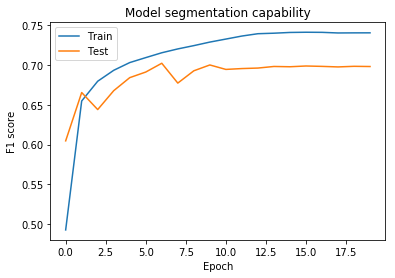

In [22]:
plt.plot(history.history["f1-score"])
plt.plot(history.history["val_f1-score"])
plt.title("Model segmentation capability")
plt.ylabel("F1 score")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc='upper left')
plt.show()

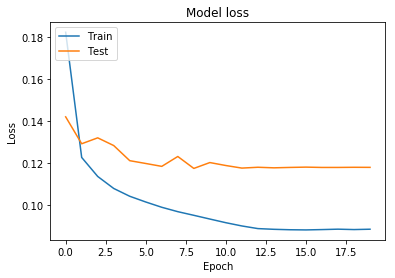

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
model.load_weights(model_path)
result = model.predict(X_val_patches)

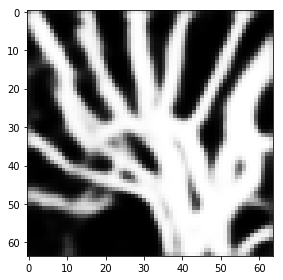

In [25]:
io.imshow(result[0, :, :, 0])

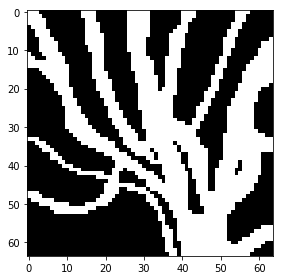

In [26]:
io.imshow(y_val_patches[0, :, :, 0])